MLP Coursework 2 ----  Zhaoyu ZHANG  ---- S1600181

# Part 1: L1 and L2 Regularisation

In [37]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)
    
class L1andL2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient_1, coefficient_2):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient_1 > 0., 'Penalty coefficient_1 must be positive.'
        assert coefficient_2 > 0., 'Penalty coefficient_2 must be positive.'
        self.coefficient_1 = coefficient_1
        self.coefficient_2 = coefficient_2
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return (self.coefficient_1 * abs(parameter).sum()) + (0.5 * self.coefficient_2 * (parameter**2).sum())
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient_1 * np.sign(parameter) + self.coefficient_2 * parameter
    
    def __repr__(self):
        return 'L1andL2Penalty(L1:{0} L2:{1})'.format(self.coefficient_1, self.coefficient_2)

In [38]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer,ReLulayers,TanhLayers
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [39]:
weights_penalties = [
    L1Penalty(1e-5),
    L2Penalty(1e-4),
    L1andL2Penalty(1e-5,1e-4)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: L1Penalty(1e-05)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.10e-02
Epoch 5: 1.94s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 1.42s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 1.42s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 1.40s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 1.41s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 3.08s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 1.83s to complet

Regularisation: L2Penalty(0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=3.69e-03
Epoch 5: 1.27s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 1.59s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 2.36s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 2.37s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 1.14s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 2.28s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 1.94s to complet

Regularisation: L1andL2Penalty(L1:1e-05 L2:0.0001)


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.80e-02, error(valid)=2.30e+00, acc(valid)=1.05e-01, params_penalty=2.47e-02
Epoch 5: 2.40s to complete
  error(train)=6.75e-02, acc(train)=9.81e-01, error(valid)=9.62e-02, acc(valid)=9.72e-01, params_penalty=3.89e-02
Epoch 10: 1.94s to complete
  error(train)=2.94e-02, acc(train)=9.92e-01, error(valid)=8.08e-02, acc(valid)=9.78e-01, params_penalty=4.21e-02
Epoch 15: 2.42s to complete
  error(train)=1.63e-02, acc(train)=9.96e-01, error(valid)=7.98e-02, acc(valid)=9.79e-01, params_penalty=4.32e-02
Epoch 20: 1.47s to complete
  error(train)=9.76e-03, acc(train)=9.98e-01, error(valid)=8.01e-02, acc(valid)=9.79e-01, params_penalty=4.28e-02
Epoch 25: 4.32s to complete
  error(train)=8.38e-03, acc(train)=9.99e-01, error(valid)=8.26e-02, acc(valid)=9.79e-01, params_penalty=4.15e-02
Epoch 30: 3.05s to complete
  error(train)=1.08e-02, acc(train)=9.98e-01, error(valid)=8.60e-02, acc(valid)=9.78e-01, params_penalty=4.00e-02
Epoch 35: 3.40s to complet

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

def plot_param_histogram(param, fig_size=(6, 3), interval=[-1.5, 1.5]):
    """Plots a normalised histogram of an array of parameter values."""
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.hist(param.flatten(), 50, interval, normed=True)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Normalised frequency density')
    return fig, ax

def visualise_first_layer_weights(weights, fig_size=(5, 5)):
    """Plots a grid of first layer weights as feature maps."""
    fig = plt.figure(figsize=fig_size)
    num_feature_maps = weights.shape[0]
    grid_size = int(num_feature_maps**0.5)
    max_abs = np.abs(model.params[0]).max()
    tiled = -np.ones((30 * grid_size, 
                      30 * num_feature_maps // grid_size)) * max_abs
    for i, fm in enumerate(model.params[0]):
        r, c = i % grid_size, i // grid_size
        tiled[1 + r * 30:(r + 1) * 30 - 1, 
              1 + c * 30:(c + 1) * 30 - 1] = fm.reshape((28, 28))
    ax = fig.add_subplot(111)
    max_abs = np.abs(tiled).max()
    ax.imshow(tiled, cmap='Greys', vmin=-max_abs, vmax=max_abs)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

Regularisation: L1Penalty(1e-05)


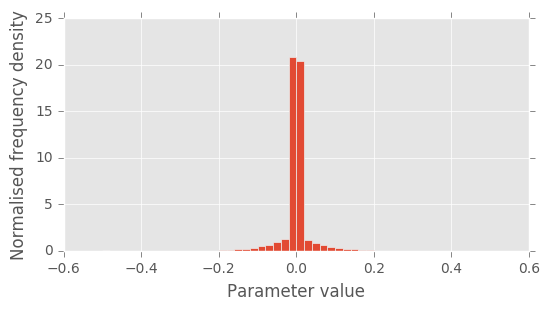

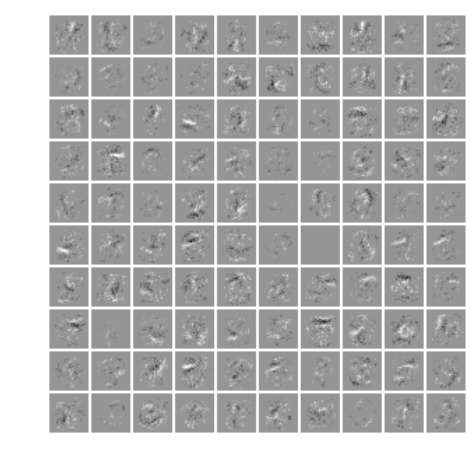

Regularisation: L2Penalty(0.0001)


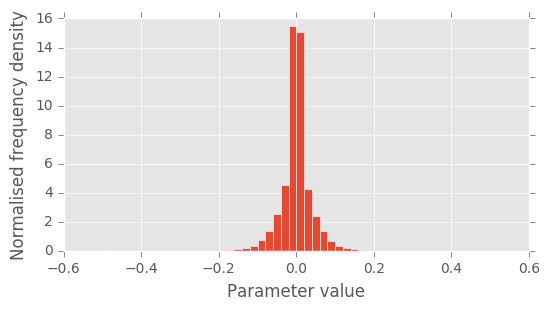

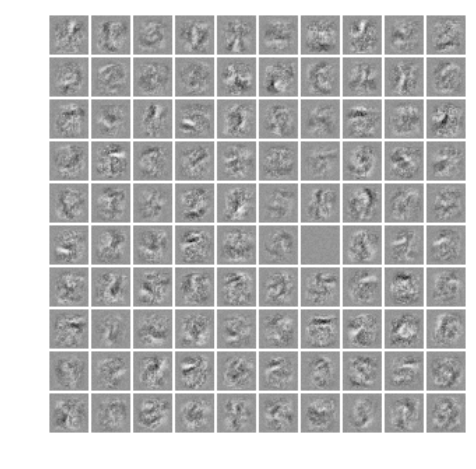

Regularisation: L1andL2Penalty(L1:1e-05 L2:0.0001)


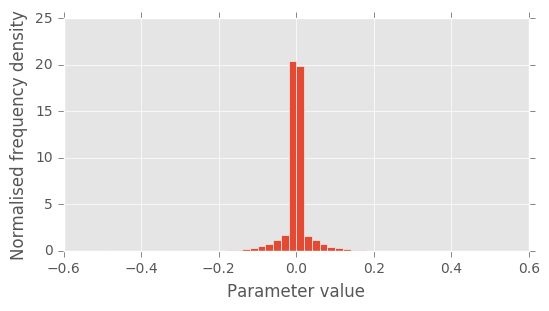

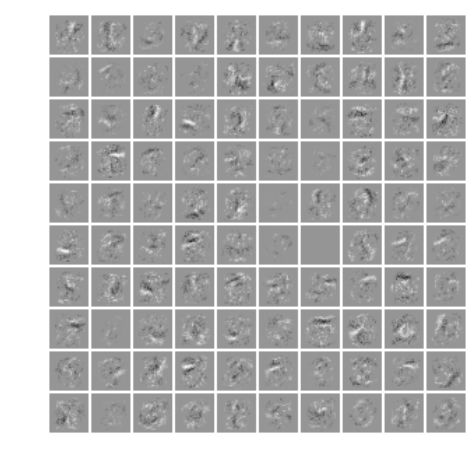

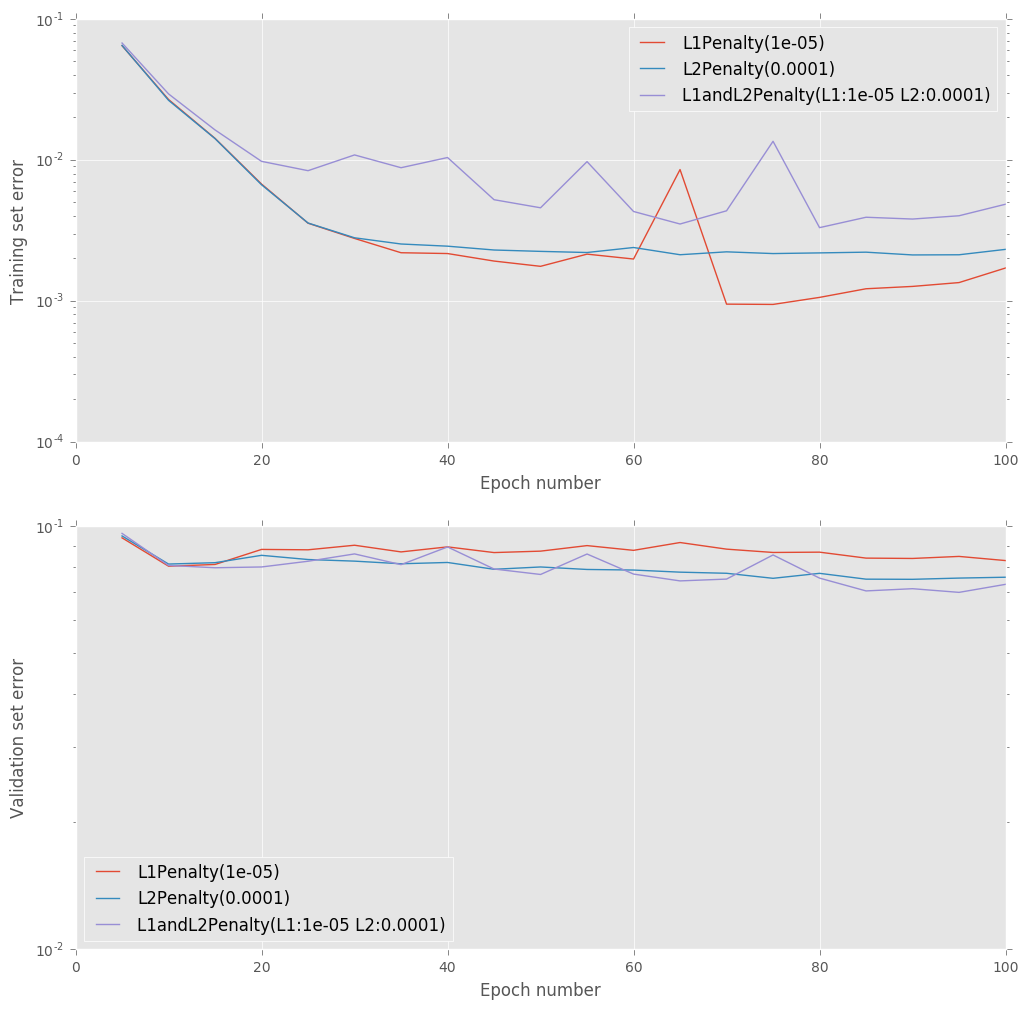

In [41]:
for weight_penalty, model in models.items():
    print('Regularisation: {0}'.format(weight_penalty))
    _ = plot_param_histogram(model.params[0], interval=[-0.5, 0.5])
    _ = visualise_first_layer_weights(model.params[0])

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=str(weight_penalty))
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=str(weight_penalty))
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

# Part 2: Data Augmentation

In [8]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)


# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

In [31]:
from scipy.ndimage.interpolation import rotate
from scipy.ndimage.interpolation import zoom
from scipy.ndimage.interpolation import shift as img_shift

def random_rotation(inputs, rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        rng: A seeded random number generator.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    angles = rng.uniform(-1., 1., size=indices.shape[0]) * 30.
    for i, j in enumerate(indices):
        new_ims[j] = rotate(orig_ims[j], angles[i], order=1, reshape=False)
    return new_ims.reshape((-1, 784))

def shift(inputs,rng):
    """Shift the images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        ratio: Shift ratio.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with shiftted image. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i in indices:
        new_ims[i] = img_shift(orig_ims[i], shift=6, order=1)
    return new_ims.reshape((-1, 784))

def zoom_in(inputs,rng):
    """Zoom in images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        ratio: zoom ratio -> ratio/1.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i in indices:
        new_ims[i] = np.zeros(new_ims[i].shape, dtype=np.double)
        new_zoom = zoom(orig_ims[i], zoom=0.85, order=1)
        start = (new_ims[i].shape[0] - new_zoom.shape[0])/2
        end = new_ims[i].shape[0] - start
        end = end if (new_zoom.shape[0] % 2) == 0 else end-1
        new_ims[i][start:end,start:end]= new_zoom
    return new_ims.reshape((-1, 784))


def zoom_out(inputs,rng):
    """Randomly rotates a subset of images in a batch.
    
    Args:
        inputs: Input image batch, an array of shape (batch_size, 784).
        ratio: zoom ratio -> ratio/1.
        
    Returns:
        An array of shape (batch_size, 784) corresponding to a copy
        of the original `inputs` array with the randomly selected
        images rotated by a random angle. The original `inputs`
        array should not be modified.
    """
    orig_ims = inputs.reshape((-1, 28, 28))
    new_ims = orig_ims.copy()
    indices = rng.choice(orig_ims.shape[0], orig_ims.shape[0] // 4, False)
    for i in indices:
        new_ims[i] = np.zeros(new_ims[i].shape, dtype=np.double)
        new_zoom = zoom(orig_ims[i], zoom=1.25, order=1)
        start = (new_zoom.shape[0] - new_ims[i].shape[0])/2
        end = new_zoom.shape[0] - start
        end = end if (new_zoom.shape[0] % 2) == 0 else end-1
        new_ims[i]= new_zoom[start:end,start:end]
    return new_ims.reshape((-1, 784))

In [32]:
from mlp.data_providers import AugmentedMNISTDataProvider


random_ratate_train_data = AugmentedMNISTDataProvider('train', rng=rng, transformer=random_rotation)
zoom_in_train_data = AugmentedMNISTDataProvider('train', transformer=zoom_in)
zoom_out_train_data = AugmentedMNISTDataProvider('train', transformer=zoom_out)
shift_train_data = AugmentedMNISTDataProvider('train', transformer=shift)
aug_train_data = {'random_ratation':random_ratate_train_data,'shift':shift_train_data,
                  'zoom_in':zoom_in_train_data,'zoom_out':zoom_out_train_data}


In [33]:
batch_size = 100
num_epochs = 100
learning_rate = 0.01
mom_coeff = 0.9
stats_interval = 5

run_info = OrderedDict()
models = OrderedDict()

for key in aug_train_data.keys():
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    aug_train_data[key].reset()
    valid_data.reset()
    aug_train_data[key].batch_size = batch_size 
    valid_data.batch_size = batch_size
    
    weights_init = GlorotUniformInit(0.5, rng=rng)
    biases_init = ConstantInit(0.)
    print('Data Augmentation Method: {}'.format(key))
    
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
    ])

    error = CrossEntropySoftmaxError()
    learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
    optimiser = Optimiser(
        model, error, learning_rule, aug_train_data[key], valid_data, data_monitors)
    run_info[key] = optimiser.train(num_epochs, stats_interval)
    models[key] = model

Data Augmentation Method: zoom_out


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.02e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 1.71s to complete
  error(train)=1.29e-01, acc(train)=9.63e-01, error(valid)=1.25e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 10: 1.52s to complete
  error(train)=7.24e-02, acc(train)=9.80e-01, error(valid)=8.79e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 1.66s to complete
  error(train)=4.85e-02, acc(train)=9.86e-01, error(valid)=7.88e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 1.41s to complete
  error(train)=3.65e-02, acc(train)=9.90e-01, error(valid)=7.87e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 25: 1.41s to complete
  error(train)=2.67e-02, acc(train)=9.93e-01, error(valid)=7.42e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.43s to complete
  error(train)=3.26e-02, acc(train)=9.90e-01, error(valid)=9.23e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 1.40s to complet

Data Augmentation Method: shift


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.04e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 0.99s to complete
  error(train)=1.52e-01, acc(train)=9.56e-01, error(valid)=1.41e-01, acc(valid)=9.61e-01, params_penalty=0.00e+00
Epoch 10: 0.95s to complete
  error(train)=8.69e-02, acc(train)=9.75e-01, error(valid)=1.02e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 15: 0.95s to complete
  error(train)=6.05e-02, acc(train)=9.83e-01, error(valid)=9.43e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 20: 1.44s to complete
  error(train)=4.71e-02, acc(train)=9.87e-01, error(valid)=9.74e-02, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 25: 0.98s to complete
  error(train)=3.60e-02, acc(train)=9.90e-01, error(valid)=1.01e-01, acc(valid)=9.73e-01, params_penalty=0.00e+00
Epoch 30: 1.79s to complete
  error(train)=3.73e-02, acc(train)=9.89e-01, error(valid)=1.11e-01, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 35: 2.07s to complet

Data Augmentation Method: zoom_in


Epoch 0:
  error(train)=2.30e+00, acc(train)=1.04e-01, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 1.19s to complete
  error(train)=1.25e-01, acc(train)=9.64e-01, error(valid)=1.26e-01, acc(valid)=9.66e-01, params_penalty=0.00e+00
Epoch 10: 1.19s to complete
  error(train)=6.93e-02, acc(train)=9.80e-01, error(valid)=9.38e-02, acc(valid)=9.75e-01, params_penalty=0.00e+00
Epoch 15: 1.21s to complete
  error(train)=4.48e-02, acc(train)=9.87e-01, error(valid)=8.26e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 20: 1.21s to complete
  error(train)=3.05e-02, acc(train)=9.91e-01, error(valid)=8.42e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 1.21s to complete
  error(train)=2.22e-02, acc(train)=9.94e-01, error(valid)=8.40e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 1.22s to complete
  error(train)=2.22e-02, acc(train)=9.93e-01, error(valid)=9.45e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 35: 1.22s to complet

Data Augmentation Method: random_ratation


Epoch 0:
  error(train)=2.30e+00, acc(train)=9.99e-02, error(valid)=2.30e+00, acc(valid)=1.06e-01, params_penalty=0.00e+00
Epoch 5: 2.66s to complete
  error(train)=1.45e-01, acc(train)=9.57e-01, error(valid)=1.23e-01, acc(valid)=9.65e-01, params_penalty=0.00e+00
Epoch 10: 2.04s to complete
  error(train)=8.53e-02, acc(train)=9.74e-01, error(valid)=8.48e-02, acc(valid)=9.74e-01, params_penalty=0.00e+00
Epoch 15: 1.52s to complete
  error(train)=6.26e-02, acc(train)=9.81e-01, error(valid)=7.69e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 20: 2.38s to complete
  error(train)=5.26e-02, acc(train)=9.85e-01, error(valid)=7.79e-02, acc(valid)=9.76e-01, params_penalty=0.00e+00
Epoch 25: 2.29s to complete
  error(train)=4.33e-02, acc(train)=9.88e-01, error(valid)=7.29e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 30: 1.89s to complete
  error(train)=3.72e-02, acc(train)=9.89e-01, error(valid)=7.23e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 35: 2.00s to complet

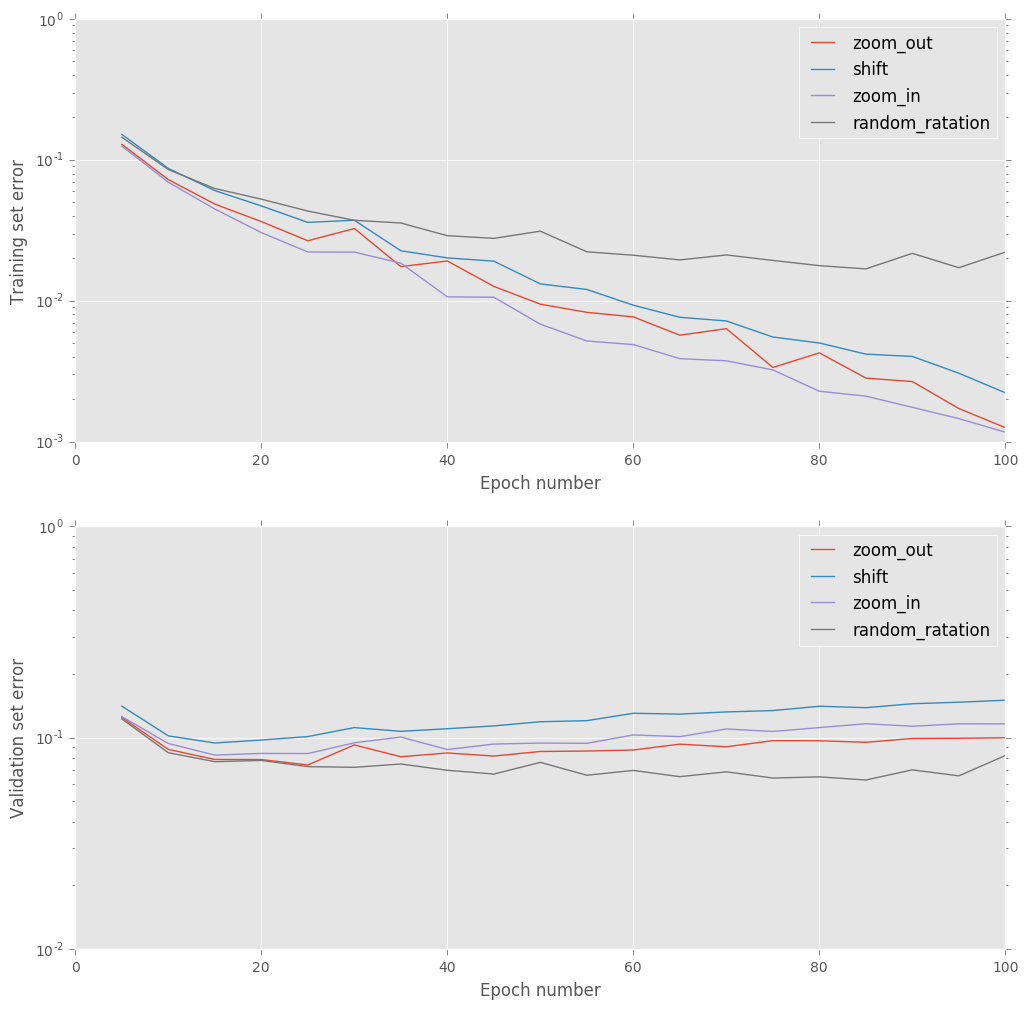

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for key, run in run_info.items():
    stats, keys, run_time = run
    ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(train)']], label=key)
    ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
             stats[1:, keys['error(valid)']], label=key)
ax1.legend(loc=0)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training set error')
ax1.set_yscale('log')
ax2.legend(loc=0)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation set error')
ax2.set_yscale('log')

# Part 3 Convolutional Layers

In [37]:
# ConvolutionalLayer
import mlp.layers as layers
import mlp.initialisers as init
from scipy import signal

class ConvolutionalLayer(layers.LayerWithParameters):
    """Layer implementing a 2D convolution-based transformation of its inputs.

    The layer is parameterised by a set of 2D convolutional kernels, a four
    dimensional array of shape
        (num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2)
    and a bias vector, a one dimensional array of shape
        (num_output_channels,)
    i.e. one shared bias per output channel.

    Assuming no-padding is applied to the inputs so that outputs are only
    calculated for positions where the kernel filters fully overlap with the
    inputs, and that unit strides are used the outputs will have spatial extent
        output_dim_1 = input_dim_1 - kernel_dim_1 + 1
        output_dim_2 = input_dim_2 - kernel_dim_2 + 1
    """

    def __init__(self, num_input_channels, num_output_channels,
                 input_dim_1, input_dim_2,
                 kernel_dim_1, kernel_dim_2,
                 kernels_init=init.UniformInit(-0.01, 0.01),
                 biases_init=init.ConstantInit(0.),
                 kernels_penalty=None, biases_penalty=None):
        """Initialises a parameterised convolutional layer.

        Args:
            num_input_channels (int): Number of channels in inputs to
                layer (this may be number of colour channels in the input
                images if used as the first layer in a model, or the
                number of output channels, a.k.a. feature maps, from a
                a previous convolutional layer).
            num_output_channels (int): Number of channels in outputs
                from the layer, a.k.a. number of feature maps.
            input_dim_1 (int): Size of first input dimension of each 2D
                channel of inputs.
            input_dim_2 (int): Size of second input dimension of each 2D
                channel of inputs.
            kernel_dim_x (int): Size of first dimension of each 2D channel of
                kernels.
            kernel_dim_y (int): Size of second dimension of each 2D channel of
                kernels.
            kernels_intialiser: Initialiser for the kernel parameters.
            biases_initialiser: Initialiser for the bias parameters.
            kernels_penalty: Kernel-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the kernels.
            biases_penalty: Biases-dependent penalty term (regulariser) or
                None if no regularisation is to be applied to the biases.
        """
        self.num_input_channels = num_input_channels
        self.num_output_channels = num_output_channels
        self.input_dim_1 = input_dim_1
        self.input_dim_2 = input_dim_2
        self.kernel_dim_1 = kernel_dim_1
        self.kernel_dim_2 = kernel_dim_2
        self.kernels_init = kernels_init
        self.biases_init = biases_init
        self.kernels_shape = (
            num_output_channels, num_input_channels, kernel_dim_1, kernel_dim_2
        )
        self.inputs_shape = (
            None, num_input_channels, input_dim_1, input_dim_2
        )
        self.kernels = self.kernels_init(self.kernels_shape)
        self.biases = self.biases_init(num_output_channels)
        self.kernels_penalty = kernels_penalty
        self.biases_penalty = biases_penalty

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x`, outputs `y`, kernels `K` and biases `b` the layer
        corresponds to `y = conv2d(x, K) + b`.

        Args:
            inputs: Array of layer inputs of shape 
                (batch_size, num_input_channels, input_dim_1, input_dim_2).

        Returns:
            outputs: Array of layer outputs of shape 
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
        """
        self.inputs = inputs
        num_line_dim1 = self.input_dim_1 - self.kernel_dim_1 + 1
        num_line_dim2 = self.input_dim_2 - self.kernel_dim_2 + 1
        self.output = np.zeros((self.inputs.shape[0], self.num_output_channels,num_line_dim1, num_line_dim2))
        
        for i in range(self.inputs.shape[0]):
            for j in range(self.num_output_channels):
                for k in range(self.num_input_channels):
                    self.output[i][j] += signal.convolve2d(self.inputs[i][k], self.kernels[j][k],mode='valid')
                self.output[i][j] += self.biases[j]
        return self.output

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.

        Args:
            inputs: Array of layer inputs of shape
                (batch_size, num_input_channels, input_dim_1, input_dim_2).
            outputs: Array of layer outputs calculated in forward pass of
                shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).
            grads_wrt_outputs: Array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            Array of gradients with respect to the layer inputs of shape
            (batch_size, num_input_channels, input_dim_1, input_dim_2).
        """
        self.grads_wrt_outputs = grads_wrt_outputs
        self.inputs = inputs
        self.gradient = np.zeros((self.inputs.shape))
        
        for i in range(self.inputs.shape[0]):
            for j in range(self.num_input_channels):
                for k in range(self.num_output_channels):
                    self.gradient[i][j] += signal.convolve2d(self.grads_wrt_outputs[i][k], self.kernels[k][j][::-1,::-1], 'full') 
        return self.gradient
        

    def grads_wrt_params(self, inputs, grads_wrt_outputs):
        """Calculates gradients with respect to layer parameters.

        Args:
            inputs: array of inputs to layer of shape (batch_size, input_dim)
            grads_wrt_to_outputs: array of gradients with respect to the layer
                outputs of shape
                (batch_size, num_output_channels, output_dim_1, output_dim_2).

        Returns:
            list of arrays of gradients with respect to the layer parameters
            `[grads_wrt_kernels, grads_wrt_biases]`.
        """
        # Gradient w.r.t Weight
        self.inputs = inputs
        self.grads_wrt_outputs = grads_wrt_outputs
        self.wrt_kernels = np.zeros((self.kernels.shape))
        for i in range(self.kernels.shape[0]):
            for j in range(self.kernels.shape[1]):
                for k in range(self.inputs.shape[0]):
                    self.wrt_kernels[i][j] += signal.convolve2d(self.inputs[k][j], self.grads_wrt_outputs[k][i][::-1,::-1], 'valid') 
        self.wrt_kernels = self.wrt_kernels[:, :, ::-1, ::-1]
        
        # Gradient w.r.t Biases
        self.wrt_biases = np.zeros((self.biases.shape))
        for i in range(self.num_output_channels):
            for j in range(self.inputs.shape[0]):
                self.wrt_biases[i] += self.grads_wrt_outputs[j][i].sum()

        return (self.wrt_kernels, self.wrt_biases)

    def params_penalty(self):
        """Returns the parameter dependent penalty term for this layer.

        If no parameter-dependent penalty terms are set this returns zero.
        """
        params_penalty = 0
        if self.kernels_penalty is not None:
            params_penalty += self.kernels_penalty(self.kernels)
        if self.biases_penalty is not None:
            params_penalty += self.biases_penalty(self.biases)
        return params_penalty

    @property
    def params(self):
        """A list of layer parameter values: `[kernels, biases]`."""
        return [self.kernels, self.biases]

    @params.setter
    def params(self, values):
        self.kernels = values[0]
        self.biases = values[1]

    def __repr__(self):
        return (
            'ConvolutionalLayer(\n'
            '    num_input_channels={0}, num_output_channels={1},\n'
            '    input_dim_1={2}, input_dim_2={3},\n'
            '    kernel_dim_1={4}, kernel_dim_2={5}\n'
            ')'
            .format(self.num_input_channels, self.num_output_channels,
                    self.input_dim_1, self.input_dim_2, self.kernel_dim_1,
                    self.kernel_dim_2)
        )

In [ ]:
# model
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [ ]:
from mlp.layers import ReshapeLayer
from mlp.layers import ReluLayer,MaxPoolingLayer
from mlp.layers import TanhLayer

rng.seed(seed)
train_data.reset()
valid_data.reset()
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

weights_init = GlorotUniformInit(0.5, rng=rng)
biases_init = ConstantInit(0.)


model = MultipleLayerModel([
    ReshapeLayer((1,28,28)),
    ConvolutionalLayer(1,10,28,28,5,5),
    ReluLayer(),
    ReshapeLayer((10*24*24,)),
    MaxPoolingLayer(4),
    AffineLayer(10*12*12, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, hidden_dim, weights_init, biases_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, weights_init, biases_init)
])

error = CrossEntropySoftmaxError()

learning_rule = MomentumLearningRule(learning_rate=learning_rate, mom_coeff=mom_coeff)
data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}
optimiser = Optimiser(
    model, error, learning_rule, train_data, valid_data, data_monitors)

stats, keys, run_time = optimiser.train(
    num_epochs=num_epochs, stats_interval=stats_interval)

Epoch 0:
  error(train)=2.30e+00, acc(train)=5.59e-02, error(valid)=2.30e+00, acc(valid)=5.27e-02, params_penalty=0.00e+00
Epoch 5: 120.54s to complete
  error(train)=3.61e-02, acc(train)=9.89e-01, error(valid)=6.04e-02, acc(valid)=9.82e-01, params_penalty=0.00e+00
Epoch 10: 120.64s to complete
  error(train)=1.68e-02, acc(train)=9.94e-01, error(valid)=5.65e-02, acc(valid)=9.84e-01, params_penalty=0.00e+00
Epoch 15: 120.40s to complete
  error(train)=7.38e-03, acc(train)=9.98e-01, error(valid)=6.37e-02, acc(valid)=9.83e-01, params_penalty=0.00e+00
Epoch 20: 120.87s to complete
  error(train)=2.46e-03, acc(train)=9.99e-01, error(valid)=5.90e-02, acc(valid)=9.87e-01, params_penalty=0.00e+00
Epoch 25: 120.29s to complete
  error(train)=2.85e-04, acc(train)=1.00e+00, error(valid)=5.95e-02, acc(valid)=9.88e-01, params_penalty=0.00e+00
Epoch 30: 122.16s to complete
  error(train)=2.59e-04, acc(train)=1.00e+00, error(valid)=6.35e-02, acc(valid)=9.88e-01, params_penalty=0.00e+00
Epoch 35: 120.